In [1]:
import os,csv,re
import pandas as pd
import numpy as np
import scanpy as sc
import math
import SpaGCN as spg
from scipy.sparse import issparse
import random, torch
import warnings
warnings.filterwarnings("ignore")
import matplotlib.colors as clr
import matplotlib.pyplot as plt
import cv2
import time
from memory_profiler import memory_usage
import torch

In [2]:
adata=sc.read_h5ad('/home/dbj/SpaLP/Tutorialdata/CosMxMouseBrain.h5ad')
adata.var_names_make_unique()
adata.obs['truth']=adata.obs['spatialClusteringAssignments']
adata.obs['truth'] = adata.obs['truth'].astype('category')
sc.pp.highly_variable_genes(adata, flavor="seurat_v3", n_top_genes=adata.shape[1])
sc.pp.normalize_total(adata, inplace=True)
sc.pp.log1p(adata)
adata

AnnData object with n_obs × n_vars = 48180 × 950
    obs: 'spatialClusteringAssignments', 'truth'
    var: 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'RNA_nbclust_clusters_colors', 'spatialClusteringAssignments_colors', 'hvg', 'log1p'
    obsm: 'spatial'

In [3]:
device_idx=0
def measure_resources(func):
    def wrapper(*args, **kwargs):
        start_time = time.time()
        mem_usage = memory_usage((func, args, kwargs), max_usage=True) / 1024
        end_time = time.time()
        execution_time = end_time - start_time
        minutes = execution_time // 60
        seconds = execution_time % 60
        if torch.cuda.is_available():
            device = torch.device(f"cuda:{device_idx}")
            allocated = torch.cuda.memory_allocated(device) / (1024 ** 3) 
            cached = torch.cuda.memory_reserved(device) / (1024 ** 3)
        else:
            allocated = cached = 0

        print(f"Function '{func.__name__}' executed in {minutes} minutes and {seconds:.4f} seconds.")
        print(f"Memory usage: {mem_usage:.2f} GB")
        print(f"GPU memory allocated: {allocated:.2f} GB")
        print(f"GPU memory cached: {cached:.2f} GB")

    return wrapper

In [4]:
@measure_resources
def run_pipeline(adata):
    adj=spg.calculate_adj_matrix(x=adata.obsm['spatial'][:,0],y=adata.obsm['spatial'][:,1], histology=False)
    p=0.5 
    #Find the l value given p
    l=spg.search_l(p, adj, start=0.001, end=1000, tol=0.01, max_run=100)
    
    n_clusters=19
    r_seed=t_seed=n_seed=400
    #Seaech for suitable resolution
    res=spg.search_res(adata, adj, l, n_clusters, start=0.7, step=0.1, tol=5e-3, lr=0.05, max_epochs=20, r_seed=r_seed, t_seed=t_seed, n_seed=n_seed)
    clf=spg.SpaGCN()
    clf.set_l(l)
    #Set seed
    random.seed(r_seed)
    torch.manual_seed(r_seed)
    np.random.seed(r_seed)
    #Run
    clf.train(adata,adj,init_spa=True,init="louvain",res=res, tol=5e-3, lr=0.05, max_epochs=200)
    y_pred, prob=clf.predict()
    adata.obs["SpaGCN"]= y_pred
    adata.obs["SpaGCN"]=adata.obs["SpaGCN"].astype('category')
run_pipeline(adata)

Calculateing adj matrix using xy only...
Run 1: l [0.001, 1000], p [8.940696716308594e-06, 48178.76474003152]
Run 2: l [0.001, 500.0005], p [8.940696716308594e-06, 48178.0625]
Run 3: l [0.001, 250.00074999999998], p [8.940696716308594e-06, 48175.234375]
Run 4: l [0.001, 125.000875], p [8.940696716308594e-06, 48163.94921875]
Run 5: l [0.001, 62.5009375], p [8.940696716308594e-06, 48118.83984375]
Run 6: l [0.001, 31.25096875], p [8.940696716308594e-06, 47939.15625]
Run 7: l [0.001, 15.625984375], p [8.940696716308594e-06, 47232.0]
Run 8: l [0.001, 7.8134921875], p [8.940696716308594e-06, 44578.03125]
Run 9: l [0.001, 3.90724609375], p [8.940696716308594e-06, 36199.30078125]
Run 10: l [0.001, 1.954123046875], p [8.940696716308594e-06, 20194.236328125]
Run 11: l [0.001, 0.9775615234374999], p [8.940696716308594e-06, 7316.0634765625]
Run 12: l [0.001, 0.48928076171874996], p [8.940696716308594e-06, 2159.353515625]
Run 13: l [0.001, 0.24514038085937498], p [8.940696716308594e-06, 590.7907104

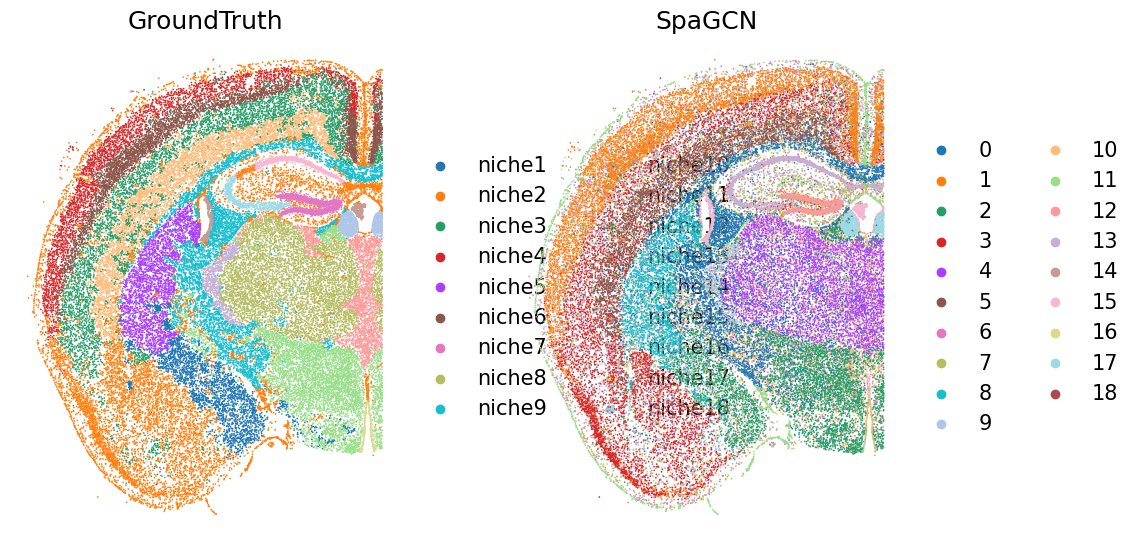

In [5]:
import matplotlib.pyplot as plt
import copy
from scanpy.plotting import palettes
plt.rcParams['figure.figsize'] = (5,6.5)
plt.rcParams['font.size'] = 15

sc.pl.embedding(adata, basis="spatial",s=6, color=['spatialClusteringAssignments','SpaGCN'],colorbar_loc=None,title='GroundTruth',frameon=False,palette=palettes.default_20)

In [6]:
import numpy as np
from sklearn.metrics import (homogeneity_score,v_measure_score,adjusted_mutual_info_score,normalized_mutual_info_score,adjusted_rand_score,fowlkes_mallows_score)

true_labels = np.array(adata.obs['spatialClusteringAssignments'])
cluster_labels = np.array(adata.obs['SpaGCN'])

FMI = fowlkes_mallows_score(true_labels, cluster_labels)
homogeneity = homogeneity_score(true_labels, cluster_labels)
v_measure = v_measure_score(true_labels, cluster_labels)
ami = adjusted_mutual_info_score(true_labels, cluster_labels)
nmi = normalized_mutual_info_score(true_labels, cluster_labels)
ari = adjusted_rand_score(true_labels, cluster_labels)

print("ARI:", ari)
print("NMI:", nmi)
print("AMI:", ami)
print("FMI:", FMI)
print("V-Measure:", v_measure)
print("Homogeneity:", homogeneity)

ARI: 0.26768892162435554
NMI: 0.44067219991135603
AMI: 0.4400052201501599
FMI: 0.3313899951213894
V-Measure: 0.4406721999113561
Homogeneity: 0.45100797078892757


In [7]:
adata.write_h5ad('/home/dbj/STAGATE/SpaGCN_CosMx_mousebrain_seed_400.h5ad',compression='gzip')